## Entrenamiento

#### Importación de las librerías

In [23]:
import pyarrow.feather as feather
import importlib
import numpy as np
import matplotlib.pyplot as plt
import utils.train_utils as train_utils
import utils.plot_utils as plot_utils
from torchsummary import summary
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
import torch
import mlflow

import pickle 
from torch import nn

importlib.reload(train_utils)
importlib.reload(plot_utils)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from utils.train_utils import Model, evaluate_model, fit_model, perform_grid_search, evaluate_model_mlflow
from sklearn.cluster import KMeans
import torch.optim as optim
from torch.utils.data import Dataset
from utils.plot_utils import plot_roc_curve
from sklearn.model_selection import GridSearchCV
from urllib.parse import urlparse
from mlflow.tracking import MlflowClient



#### Create mlflow experiment

In [17]:
client = MlflowClient()
experiment_id = client.create_experiment("airport")

#### Cargado de datos

In [2]:
X_train = feather.read_feather("./results/X_train.ftr")
X_test = feather.read_feather("./results/X_test.ftr")
y_train = feather.read_feather("./results/y_train.ftr").to_numpy().ravel()
y_test = feather.read_feather("./results/y_test.ftr").to_numpy().ravel()

In [4]:
models = {}

### Adaboost

ROC_AUC = 0.9285620168587724

              precision    recall  f1-score   support

           0    0.94090   0.93193   0.93639     14573
           1    0.91405   0.92520   0.91959     11403

    accuracy                        0.92897     25976
   macro avg    0.92748   0.92856   0.92799     25976
weighted avg    0.92912   0.92897   0.92902     25976

Training time: 9.604002300000047 s


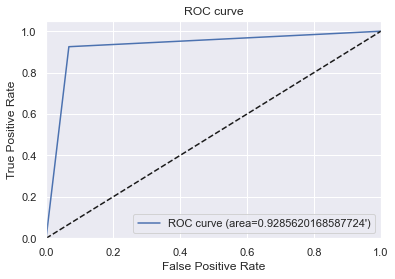

In [32]:
params = {
    "n_estimators": 100,
    "random_state": 0,
}

model = Model(AdaBoostClassifier, params)
        
evaluate_model(model, X_train, y_train, X_test, y_test)
models["model_ad"] = model

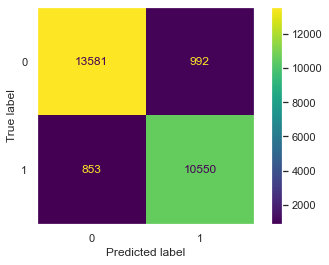

In [33]:
model.confusion_matrix(X_test, y_test)

### SVM

ROC_AUC = 0.9548056568894316

              precision    recall  f1-score   support

           0    0.96134   0.95890   0.96012     14573
           1    0.94764   0.95071   0.94917     11403

    accuracy                        0.95530     25976
   macro avg    0.95449   0.95481   0.95465     25976
weighted avg    0.95532   0.95530   0.95531     25976

Training time: 287.0144499999999 s


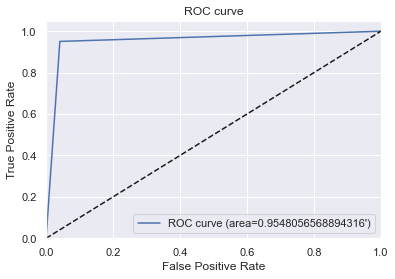

In [34]:
params = {}

model = Model(SVC, params)
evaluate_model(model, X_train, y_train, X_test, y_test)
models["model_svm"] = model

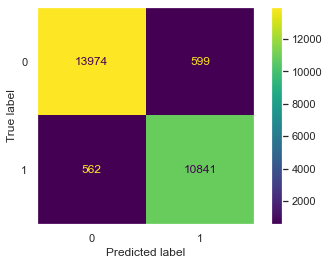

In [35]:
model.confusion_matrix(X_test, y_test)

### Decision tree

{'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}
Grid search time: 12.095472900000004 s
ROC_AUC = 0.889577695069043

              precision    recall  f1-score   support

           0    0.91632   0.88211   0.89889     14573
           1    0.85620   0.89704   0.87615     11403

    accuracy                        0.88867     25976
   macro avg    0.88626   0.88958   0.88752     25976
weighted avg    0.88993   0.88867   0.88890     25976

Training time: 0.3907411999998658 s


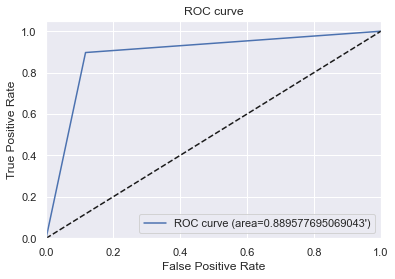

In [20]:
params = {'criterion': ['gini','entropy'], 'splitter': ['best','random'], 'max_depth': [2,3,4]}
model = Model(DecisionTreeClassifier, {})
perform_grid_search(model, X_train, y_train, params)

params = model.best_params
model = Model(DecisionTreeClassifier, params)
evaluate_model(model, X_train, y_train, X_test, y_test)

models["model_dt"] = model

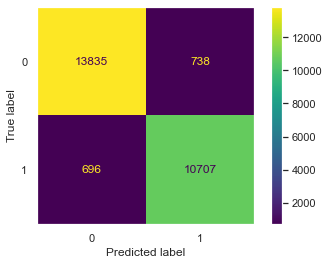

In [37]:
model.confusion_matrix(X_test, y_test)

### Bagging

ROC_AUC = 0.9588117036379983

              precision    recall  f1-score   support

           0    0.95672   0.97392   0.96525     14573
           1    0.96589   0.94370   0.95467     11403

    accuracy                        0.96066     25976
   macro avg    0.96131   0.95881   0.95996     25976
weighted avg    0.96075   0.96066   0.96060     25976

Training time: 51.88874099999998 s


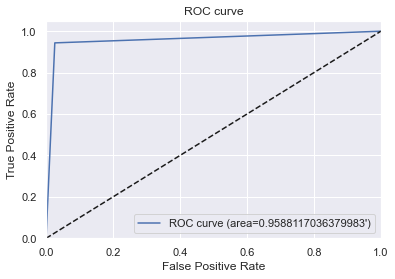

In [38]:
params = {
    'random_state': 42,
    "base_estimator": DecisionTreeClassifier(),
    "bootstrap_features": False,
    "n_estimators": 100, 
}


model = Model(BaggingClassifier, params)
evaluate_model(model, X_train, y_train, X_test, y_test)
models["model_bg"] = model


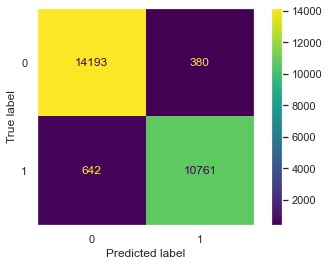

In [39]:
model.confusion_matrix(X_test, y_test)

### Random forest

ROC_AUC = 0.9615529341528721

              precision    recall  f1-score   support

           0    0.95890   0.97660   0.96767     14573
           1    0.96937   0.94651   0.95780     11403

    accuracy                        0.96339     25976
   macro avg    0.96414   0.96155   0.96274     25976
weighted avg    0.96350   0.96339   0.96334     25976

Training time: 294.36952039999983 s


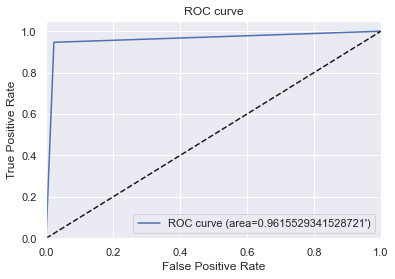

In [40]:
params = {
    'max_depth': 25,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 1200,
    'random_state': 42
}

model = Model(RandomForestClassifier, params)

evaluate_model(model, X_train, y_train, X_test, y_test)
models["model_rf"] = model

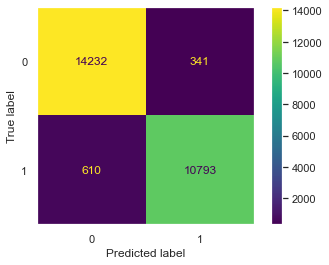

In [41]:
model.confusion_matrix(X_test, y_test)

### Logistic regression

{'random_state': 35}
Grid search time: 9.720463599995128 s
ROC_AUC = 0.859699316601944

              precision    recall  f1-score   support

           0    0.89560   0.84533   0.86974     14573
           1    0.81556   0.87407   0.84380     11403

    accuracy                        0.85795     25976
   macro avg    0.85558   0.85970   0.85677     25976
weighted avg    0.86047   0.85795   0.85835     25976

Training time: 0.48503949999576434 s


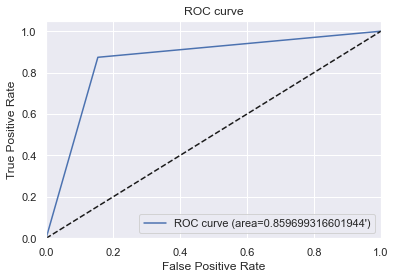

In [24]:
params = {'random_state': [35, 40, 45]}
model = evaluate_model_mlflow(LogisticRegression, X_train, y_train, X_test, y_test, params, models, "model_lr", experiment_id) 

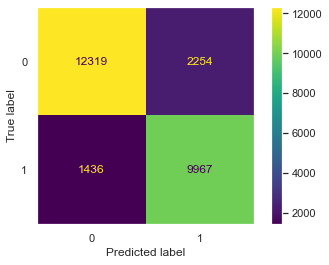

In [43]:
model.confusion_matrix(X_test, y_test)

### K means

{'n_clusters': 2, 'random_state': 0}
Grid search time: 18.573254000002635 s
ROC_AUC = 0.7740498820409712

              precision    recall  f1-score   support

           0    0.84229   0.72051   0.77666     14573
           1    0.69852   0.82759   0.75760     11403

    accuracy                        0.76752     25976
   macro avg    0.77041   0.77405   0.76713     25976
weighted avg    0.77918   0.76752   0.76829     25976

Training time: 1.5106846999988193 s


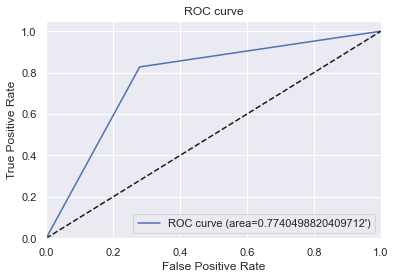

In [20]:
params = {'random_state': [0, 2], "n_clusters": [2]}
model = evaluate_model_mlflow(KMeans, X_train, y_train, X_test, y_test, params, models, "model_km", experiment_id) 

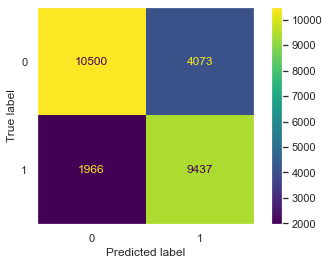

In [45]:
model.confusion_matrix(X_test, y_test)

In [46]:
kmeans_silhouette = silhouette_score(X_train, model.model.labels_).round(2)

In [47]:
print(f"Kmeans silhouette score: {kmeans_silhouette}")

Kmeans silhouette score: 0.15


### Neural network

In [48]:
# Se crea el modelo a entrenar
class Net(nn.Module, Model):
    def __init__(self):
        super(Net, self).__init__()

        self.layer_1 = nn.Linear(19, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x
    
    def predict(self, X):
        X = torch.tensor(X.values).float().detach()
        y_pred = torch.round(torch.sigmoid(self.forward(X))).detach().numpy()
        return y_pred
        
model = Net()

In [49]:
# Se define el dataset
class CustomDataset(Dataset):
  def __init__(self, X, Y):
    super().__init__()
    self.X = torch.tensor(X.values).float()
    self.Y = torch.tensor(Y).float()

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    x = self.X[idx]
    y = self.Y[idx]
    return x, y

In [50]:
# Se crean los dataloaders
params = {
    'batch_size': 64,
    'shuffle': True,
}

train_set = CustomDataset(X_train, y_train)
test_set = CustomDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, **params)
test_loader = torch.utils.data.DataLoader(test_set, **params)

In [51]:
# Se entrena el modelo
dataloaders = {"train": train_loader, "val": test_loader,}
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01,)

In [52]:
losses_train, losses_val, train_time = fit_model(model, criterion, optimizer, dataloaders, len(train_set), len(test_set), epochs=5)

cpu
[1] training loss: 0.15962, validation loss: 0.11457, train accuracy 93.2590560913086, val accuracy 95.16091918945312
[2] training loss: 0.12227, validation loss: 0.10038, train accuracy 94.8130874633789, val accuracy 95.7961196899414
[3] training loss: 0.11333, validation loss: 0.10411, train accuracy 95.11031341552734, val accuracy 95.46504211425781
[4] training loss: 0.10870, validation loss: 0.09951, train accuracy 95.25807189941406, val accuracy 95.77687072753906
[5] training loss: 0.10631, validation loss: 0.09619, train accuracy 95.4168701171875, val accuracy 96.00785064697266


ROC_AUC = 0.9577819966802772

              precision    recall  f1-score   support

           0    0.95338   0.97660   0.96485     14573
           1    0.96913   0.93896   0.95381     11403

    accuracy                        0.96008     25976
   macro avg    0.96126   0.95778   0.95933     25976
weighted avg    0.96029   0.96008   0.96000     25976



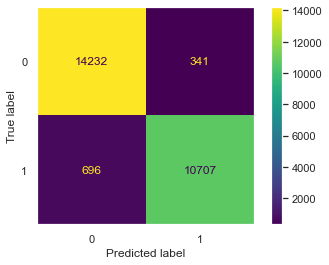

In [53]:
model.classification_report(X_test, y_test)
model.confusion_matrix(X_test, y_test)
model.train_time = train_time
models["model_nn"] = model

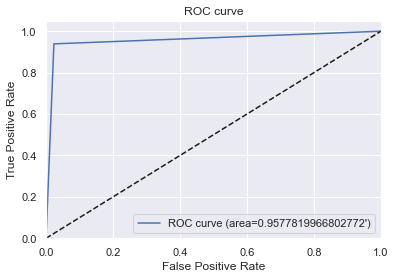

In [54]:
model.plot_curve(X_test, y_test)

### Guardar modelos

In [55]:
for name, obj in models.items():
    file_to_store = open(f"./results/models/{name}.pickle", "wb")
    pickle.dump(obj, file_to_store)